In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


In [2]:
read_dp <- function(arch, capture, coverages) {
    arch_gt <-
        future_map(coverages, function(x) {
            read_vcf(here(paste0("data/vcf/full_", arch, ".vcf.gz")), mindp = x, var_only = TRUE) %>%
                select(!!arch) %>%
                setNames(paste0(arch, "_dp", x))
        }) %>% bind_cols

    pos <- read_vcf(here(paste0("data/vcf/full_", arch, ".vcf.gz")), mindp = 1, var_only = TRUE) %>%
        select(chrom, pos, REF, ALT)
    
    bind_cols(pos, arch_gt)
}

## Read genotypes

In [3]:
gt_den4 %<-% read_dp("den4", "full", 1:10)
gt_den8 %<-% read_dp("den8", "full", 1:10)
gt_spy1 %<-% read_dp("spy1", "full", 1:10)
gt_mez2 %<-% read_dp("mez2", "full", 1:10)

In [4]:
gt_high <-
    read_vcf(here(paste0("data/vcf/full_highcov.vcf.gz")), mindp = 3, var_only = TRUE) %>%
    select(chrom, pos, REF, ALT, S_French_1, S_Papuan_2, S_Burmese_1, S_Thai_1, S_Sardinian_1)

## Calculate proportions of genotyped SNP

In [5]:
raw_den4 <- snp_props(gt_den4)
raw_den8 <- snp_props(gt_den8)
raw_spy1 <- snp_props(gt_spy1)
raw_mez2 <- snp_props(gt_mez2)
raw_high <- snp_props(gt_high)

In [6]:
den4 <- snp_props(gt_den4, normalize = "T-C")
den8 <- snp_props(gt_den8, normalize = "T-C")
spy1 <- snp_props(gt_spy1, normalize = "T-C")
mez2 <- snp_props(gt_mez2, normalize = "T-C")
high <- snp_props(gt_high, normalize = "T-C")

Average out the modern human SNP counts to have a baseline to compare ancient samples to:

In [7]:
modern <- select(high, -snp) %>%
    mutate(snp = high$snp, modern = rowMeans(.)) %>%
    select(snp, modern) %>%
    gather(mindp, proportion, -snp)

Bind all ancient SNP counts into a single data frame:

In [20]:
props <- bind_rows(
    den8 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Denisova 8"),
    den4 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Denisova 4"),
    spy1 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Spy 1"),
    mez2 %>% gather(mindp, proportion, -snp) %>% mutate(ind = "Mezmaiskaya 2")
) %>%
    mutate(mindp = as.factor(as.numeric(str_replace(mindp, ".*_dp", ""))))

Warning message:
“Removed 120 rows containing missing values (geom_point).”Warning message:
“Removed 120 rows containing missing values (geom_path).”

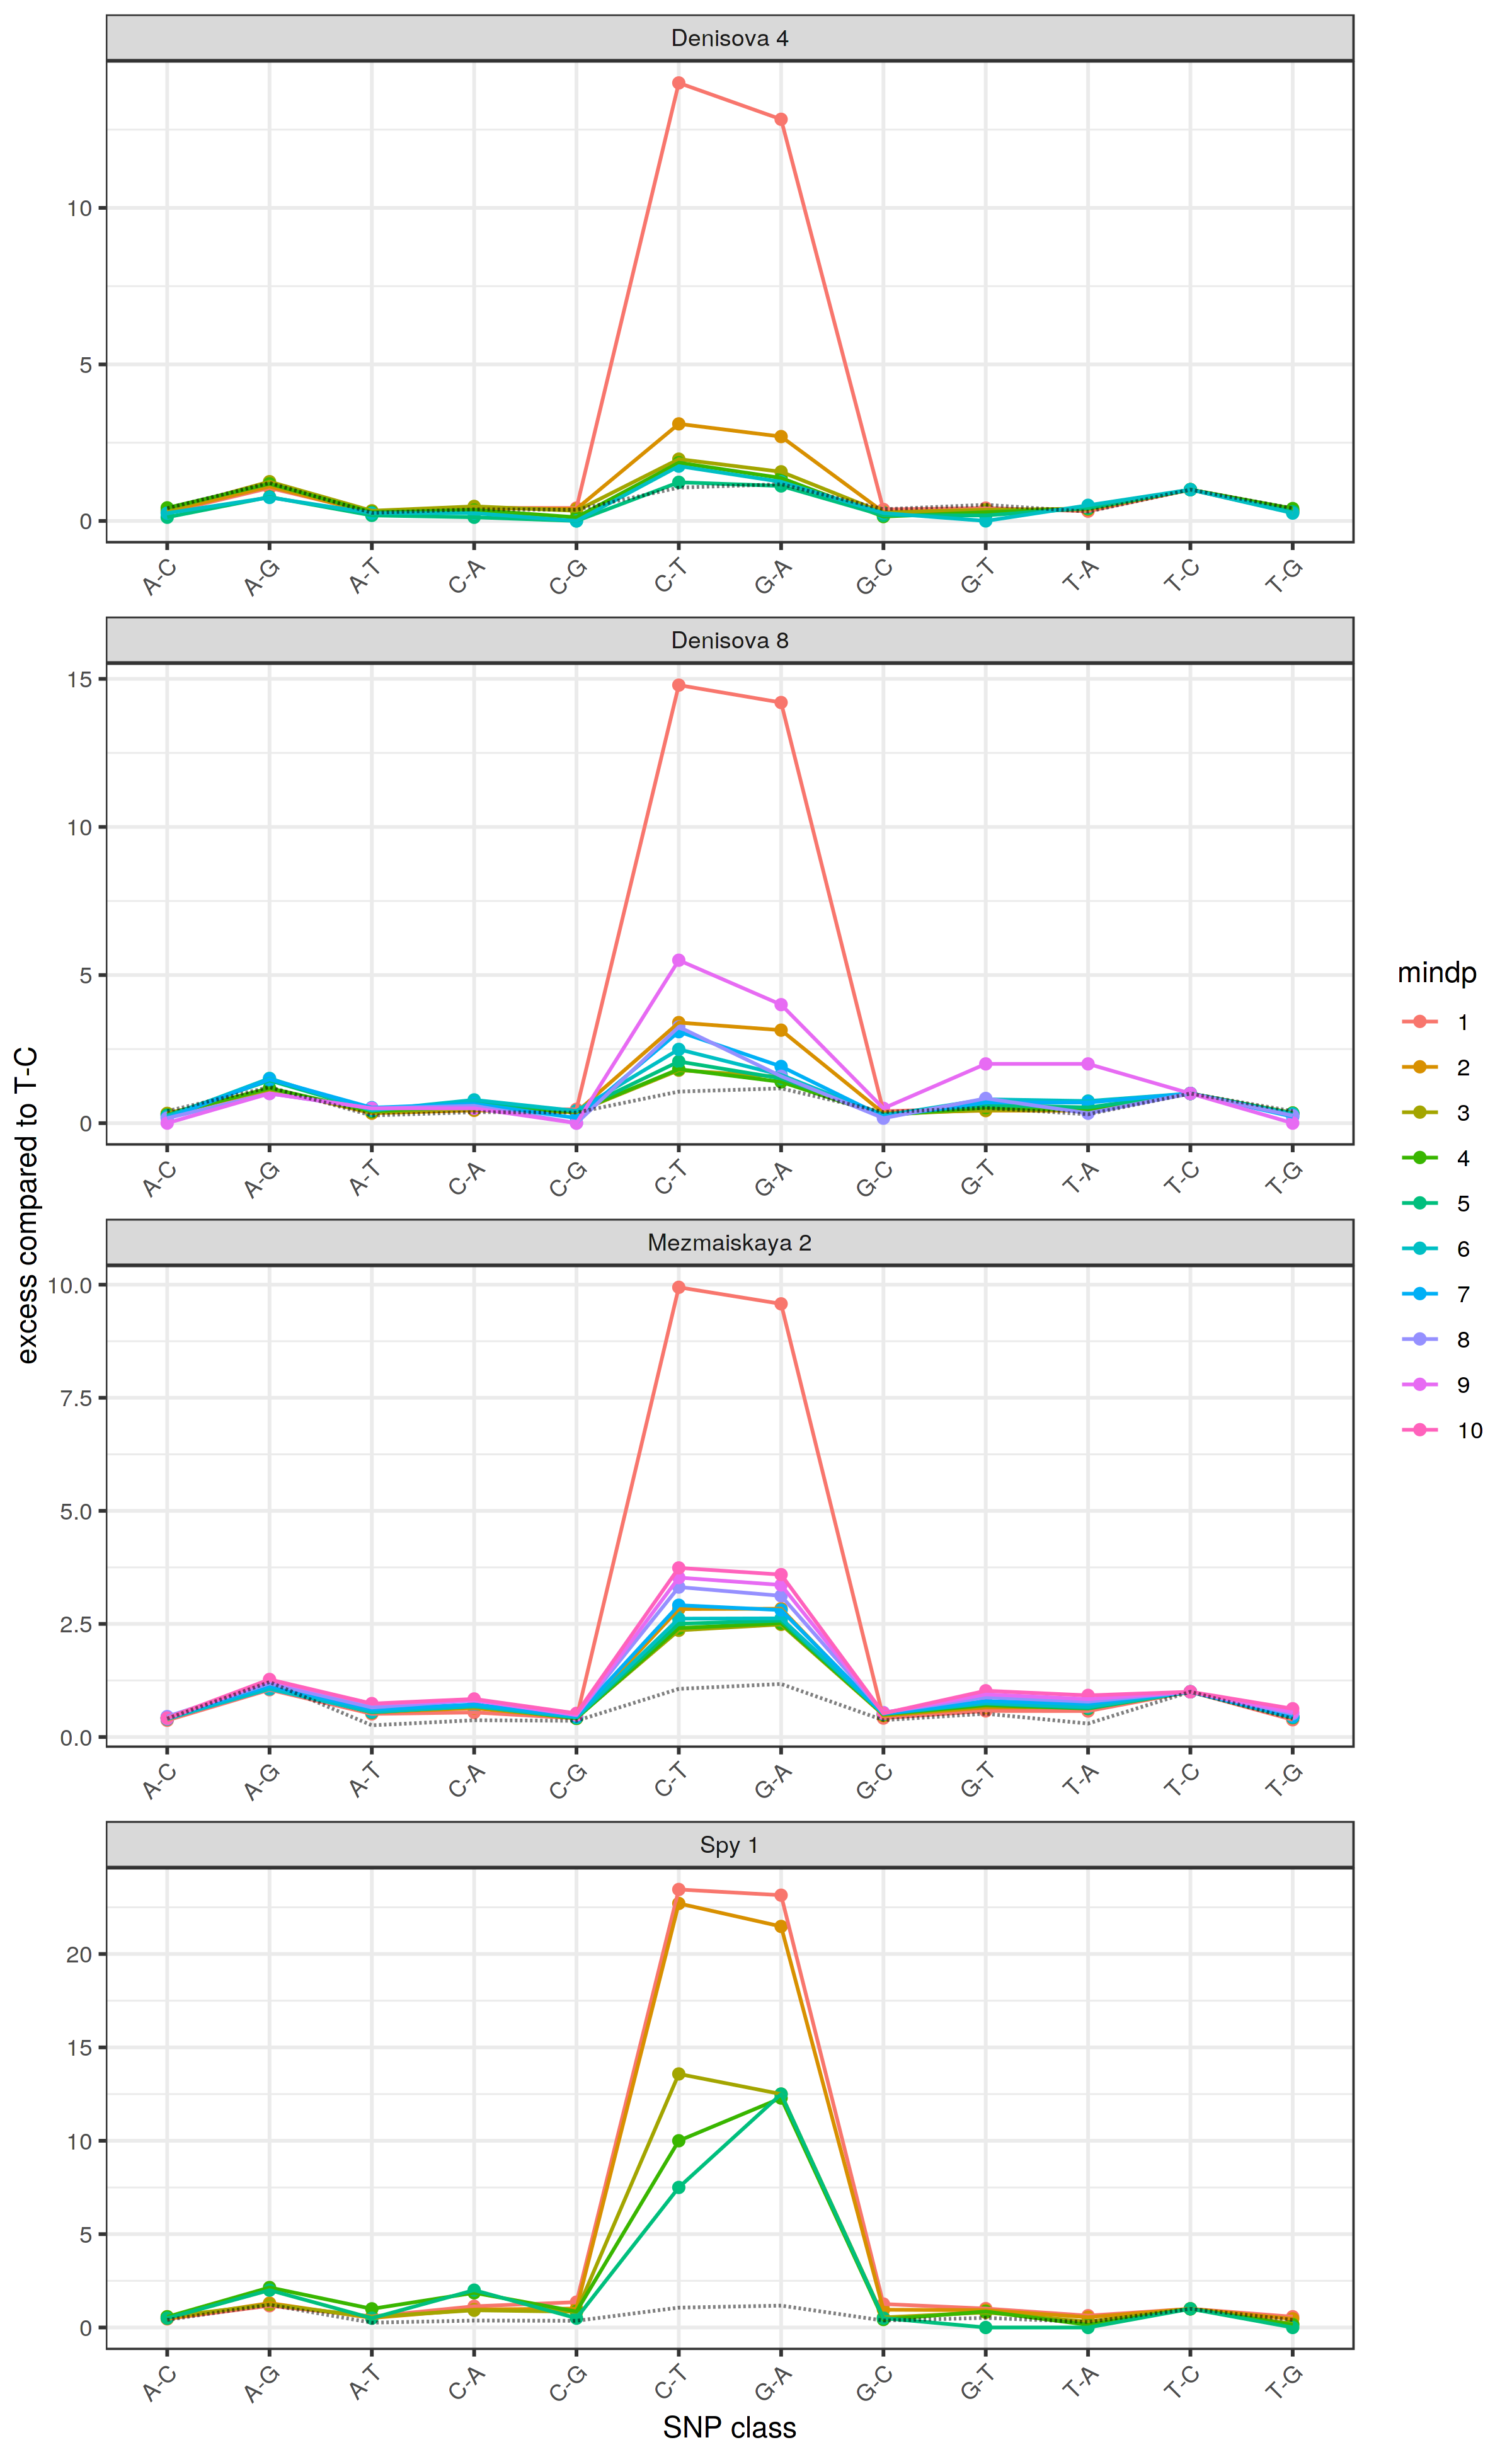

In [26]:
set_dim(8, 13)

props %>%
ggplot(aes(snp, proportion, color = mindp)) +
    geom_point() +
    geom_line(aes(group = mindp)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    xlab("SNP class") + ylab("excess compared to T-C") +
    guides(linetype = FALSE, shape = FALSE) +
    geom_line(data = modern, group = 1, color = "black", linetype = 2, alpha = 1/2) +
    facet_wrap(~ ind, scales = "free", ncol = 1)